In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
import base64
import glob
import io
from IPython.display import HTML
from IPython import display 

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Flatten image and remove walls

In [3]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX

# max_env_steps = 100

class FlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.
        
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        # self.unwrapped.max_steps = max_env_steps

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)
        
        flattened_grid = full_grid.ravel()
        return flattened_grid
    
    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

# Add goal state

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import random
from torch.distributions.multivariate_normal import MultivariateNormal

BATCH_SIZE = 128 # 128
UPDATE_STEP = 4 # 4
BUFFER_SIZE = 100000 # 100000
LEARNING_RATE = 1e-3 # 5e-3
GAMMA = 0.9 # 0.9
EPS_START = 1 # 1
EPS_END = 0.1 # 0.1
EPS_DECAY = 0.995 # 0.995
TAU=1e-3 # 1e-3
EPSILON = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

    
class MasterNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

#     def __init__(self, state_size, seed=42, hidden_size1=64, hidden_size2=64):
#         super(MasterNetwork, self).__init__()
#         self.seed = torch.manual_seed(seed)
#         self.layer1 = nn.Linear(state_size, hidden_size1)
#         self.layer2 = nn.Linear(hidden_size1, hidden_size2)
#         self.layer3 = nn.Linear(hidden_size2, state_size)

#     def forward(self, goal_states):
#         x = F.relu(self.layer1(goal_states))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)

    def __init__(self, state_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(MasterNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.mu = nn.Linear(hidden_size2, state_size)
        self.sigma = nn.Linear(hidden_size2, state_size) 
    
    def forward(self, states, goal_states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        mu = self.mu(x)
        cov = F.softplus(self.sigma(x))  # Make matrix positive definite
        cov = torch.diag_embed(cov) # Distibute covariances
        state_dist = MultivariateNormal(mu, cov)
        state_log_probs = state_dist.log_prob(goal_states)
        return state_log_probs
    
    def sample_goal(self, states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        mu = self.mu(x)
        cov = torch.ones(mu.size()) # Make matrix positive definite
        cov = torch.diag_embed(cov) # Distibute covariances
        state_dist = MultivariateNormal(mu, cov)
        goal_states = state_dist.sample()
        return goal_states.detach()
    
class WorkerNetwork(nn.Module):
    """
    Simple multilayer network for DQN agent
    """

    def __init__(self, state_size, action_size, seed=42, hidden_size1=64, hidden_size2=64):
        super(WorkerNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)    
        self.layer1 = nn.Linear(state_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(state_size + hidden_size2, hidden_size2)
        self.layer4 = nn.Linear(hidden_size2, action_size)

    def forward(self, states, goal_states):
        x = F.relu(self.layer1(states))
        x = F.relu(self.layer2(x))
        x = torch.cat((goal_states, x), 1)
        x = F.relu(self.layer3(x))
        return self.layer4(x)  
    

class MasterWorkerNetwork(nn.Module):
    """
    Master-Worker model
    """
    
    def __init__(self, state_size, action_size, pretrain=True, seed=42):
        super(MasterWorkerNetwork, self).__init__()
        self.pretrain = pretrain
        self.master = MasterNetwork(state_size)
        self.worker = WorkerNetwork(state_size, action_size)
        
    def forward(self, states, goal_states):
        if self.pretrain:
            return self.worker.forward(states, goal_states), None
        else:
            goal_log_probs = self.master.forward(states, goal_states)
            return self.worker.forward(states, goal_states), goal_log_probs


class DQNAgentGoal:
    """ An agent implementing Deep Q-Network algorithm"""
    
    def __init__(self, state_size, action_size, pretrain=True, emb_size=64, seed=42):
        """Initializes an Agent.
        
        Params:
        -------
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.qnetwork_local = MasterWorkerNetwork(state_size, action_size).to(device)
        self.qnetwork_target = MasterWorkerNetwork(state_size, action_size).to(device)
        self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size
        self.buffer = deque(maxlen=BUFFER_SIZE) 
        self.step = 0
        self.eps = EPS_START
        self.explore = True
        
        
    def disable_pretrain(self, learning_rate=0.1):
        
        for param in self.qnetwork_local.worker.parameters():
            param.requires_grad = False
        
        self.qnetwork_local.pretrain = False
        self.qnetwork_target.pretrain = False
        
        trainable = filter(lambda p: p.requires_grad, self.qnetwork_local.parameters())
        optimizer = optim.Adam(trainable, lr=learning_rate)
            
   
    def reset_episode(self):
        """
        Resets episode and update epsilon decay
        """
        self.eps = max(EPS_END, EPS_DECAY*self.eps) 
        
        
    def learn(self):
        """
        Learns values-actions network
        
        """
        
        # Sample batch from replay buffer
        states, next_states, goal_states, actions, rewards, dones = self.sample_batch()
        
        
        if self.qnetwork_local.pretrain:
            
            values, _ = self.qnetwork_target.forward(next_states, goal_states)
            values = values.detach()
            targets = rewards + GAMMA * values.max(1)[0].view(dones.size()) * (1 - dones)
            outputs, goal_log_probs = self.qnetwork_local.forward(states, goal_states)
            outputs = outputs.gather(1, actions.long())
                
            self.optimizer.zero_grad()
            loss = F.mse_loss(outputs, targets)
            loss.backward()
            self.optimizer.step()
        else:
            
            values_old, goal_log_probs_old = self.qnetwork_target.forward(states, goal_states)
            values_old = values_old.gather(1, actions.long()).detach()
            
            values, goal_log_probs = self.qnetwork_local.forward(states, goal_states)
            outputs = values.gather(1, actions.long())
            
            values_next_old, _ = self.qnetwork_target.forward(next_states, goal_states)
            values_next_old = values_next_old.max(1)[0].view(dones.size()).detach()
            
            targets = rewards + GAMMA * values_next_old*(1-dones)
            
            ratios = torch.exp(goal_log_probs - goal_log_probs_old.detach())
            advantages = self._compute_advantages(rewards, values_old, values_next_old, dones)
            
            self.optimizer.zero_grad()
            
            s1 = ratios * advantages
            s2 = torch.clamp(ratios, 1 - EPSILON, 1 + EPSILON) * advantages
            loss = -torch.min(s1, s2).mean()
            loss.backward()
            self.optimizer.step()
            
    def _compute_advantages(self, rewards, values, next_values, dones):
        return rewards + GAMMA * next_values*(1-dones) - values
#         td_errors = rewards + GAMMA * next_values*(1-dones) - values
#         A, advantages = 0, []
#         for t in reversed(range(len(td_errors))):
#             A = td_errors[t] + (LAMBDA * GAMMA)*A*(1-dones[t])
#             advantages.insert(0, A)
#         return torch.from_numpy(np.array(advantages)).float().to(device)
            
            
    def update(self, state, goal_state, action, reward, next_state, done):
        """
        Makes an update step of algorithm and append sars to buffer replay
        
        Params:
        -------
        state - current state
        action - action made
        reward - reward for an action
        next_state - next state from env
        done - episode finishing flag
        """
        self.buffer.append((state, next_state, goal_state, action, reward, float(done)))
        
        self.step = (self.step+1)%UPDATE_STEP
        if self.step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
                self.reset_target_network()
        
        
    def reset_target_network(self):
        """
        Resets params of target network to values from local network
        """
        params = zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters())
        for target_param, local_param in params:
            updated_params = TAU*local_param.data + (1-TAU)*target_param.data
            target_param.data.copy_(updated_params)
        
        
    def act(self, state, goal_state):
        """
        Selects action from state if epsilon-greedy way
        
        Params:
        state - current state
        
        """
        self.step+=1
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values, _ = self.qnetwork_local(torch.from_numpy(np.vstack([state])).float().to(device), 
                                                   torch.from_numpy(np.vstack([goal_state])).float().to(device))  
        self.qnetwork_local.train()
            
        if (random.random() > self.eps) and self.explore:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def sample_batch(self):
        """
        Samples a batch of experience from replay buffer random uniformily
        """
        batch = random.sample(self.buffer, k=BATCH_SIZE)
        f = lambda arr: torch.from_numpy(np.vstack(arr)).float().to(device)
        states, next_states, goal_states, actions, rewards, dones = map(f, zip(*batch))
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        return states, next_states, goal_states, actions, rewards, dones

Running on device: cpu


In [5]:
import gym

def to_coords(state):
    idx = state[0:-1:3]
    n = int(np.sqrt(len(idx)))
    for i in range(n):
        for j in range(n):
            k = n*i + j
            if (idx[k] == 10) or (idx[k] == 8):
                return np.array([i+1, j+1])
            
            
class CuriosityWrapper(gym.Wrapper):
    
    def __init__(self, env):
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        self.max_visited_states = 100
        self.max_steps = 100
        self.visited_states = deque(maxlen=self.max_visited_states)
        super().__init__(env)
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, _, _, info = self.env.step(action)
        
        if tuple(state) in self.visited_states:
            reward = -1
        else:
            reward = 1
            
        done = False
        
        if self.step_count >= self.max_steps:
            done = True
        
        self.visited_states.append(tuple(state))
            
        return next_state, reward, done, info
    
    def reset(self):
        self.visited_states = deque(maxlen=self.max_visited_states)
        return self.env.reset()
            

class RandomPosAndGoalWrapper(gym.Wrapper):
    
    def reset(self):
        
        # Generate goal state
        self.env.unwrapped.agent_pos = np.random.randint(1, self.grid_size-2, 2) 
        self.goal_state = self.env.observation(self.env.unwrapped.gen_obs())
        goal_pos = to_coords(self.goal_state)
        
        # Set initial state
        self.env.reset()
        radius = self.grid_size-2
        init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1
        while (init_pos==goal_pos).all():
            init_pos = (goal_pos + np.random.randint(0, radius, 2))%(self.grid_size-2) + 1
            
        self.env.unwrapped.agent_pos = init_pos
        
        # Return initial state 
        return self.env.observation(self.env.unwrapped.gen_obs())
    
    def __init__(self, env):
        self.goal_state = None
        self.grid_size = env.unwrapped.grid.encode().shape[0]
        super().__init__(env)
        
        
    def step(self, action):
        state = self.env.observation(self.env.unwrapped.gen_obs())
        next_state, reward, done, info = self.env.step(action)
        cur_pos, next_pos, goal_pos = to_coords(state), to_coords(next_state), to_coords(self.goal_state)
        dist1 = np.linalg.norm(cur_pos - goal_pos)
        dist2 = np.linalg.norm(next_pos - goal_pos)
        
        reward = (dist1 - dist2)
        reward = 1 - np.sqrt(2) if reward == 0 else reward
        
        if (next_pos == goal_pos).all() or (self.step_count  >= self.max_steps):
            done = True
        else: 
            done = False
        
        return next_state, reward, done, info
    
            
from gym.wrappers import Monitor

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

def gen_wrapped_env(env_name):
    env = FlatObsWrapper(gym.make(env_name))
    env = RandomPosAndGoalWrapper(env)
    return wrap_env(env)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_episode(env, agent, pretrain=True, train_mode=True, show_steps=False):
    """
    A hepler function for running single episode
    """
    
    state = env.reset() 
    if not train_mode:
        agent.expore = False
        if pretrain:
            print("From ", to_coords(state), "to", to_coords(env.goal_state))
    score = 0 
    done = False
    
    steps = 0
    while not done:
        if pretrain:
            goal_state = env.goal_state
            action = agent.act(state, goal_state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, goal_state, action, reward, next_state, done)
            state = next_state
            score += reward
            steps+=1
        else:
            # Sample goal
            gs = torch.from_numpy(np.vstack([state])).float().to(device)
            goal_state = agent.qnetwork_local.master.sample_goal(gs).cpu().data.numpy()
            for _ in range(1): # 5
                action = agent.act(state, goal_state)
                next_state, reward, done, _ = env.step(action)
                agent.update(state, goal_state, action, reward, next_state, done)
                state = next_state
                score += reward  
                steps+=1
                if done:
                    break
   
        if (not train_mode) and show_steps:
            img = env.render('rgb_array')
            plt.imshow(img);
            plt.show()
        
            
    agent.reset_episode()
    env.close()
    
    if not train_mode:
        show_video()
    
    return score, steps

def run_episodes_and_display(env, agent, pretrain=True, n_episodes=1000):
    """
    Runs a series of episode and display agent's performance
    """
    
    display_step = 100
    score = 0
    score_sum = 0
    scores = []
    steps = []
    for episode in range(1, n_episodes+1):
        score, step = run_episode(env, agent, pretrain=pretrain, train_mode=True)
        score_sum += score
        scores.append(score)
        steps.append(step)
        if episode%display_step==0:
            avg_score = score_sum/display_step
            print("Episode: {}. Average score: {}".format(episode, avg_score))
            score_sum = 0
            
    fig = plt.figure()
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Max Score')
    plt.xlabel('Episode #')
    plt.show()
    
    fig = plt.figure()
    plt.plot(np.arange(len(steps)), steps)
    plt.ylabel('Steps')
    plt.xlabel('Episode #')
    plt.show()

Episode: 100. Average score: -21.16234708392317
Episode: 200. Average score: -3.119241555238092
Episode: 300. Average score: -0.455021310380857
Episode: 400. Average score: -1.9713766340971506
Episode: 500. Average score: -1.5534844921687856


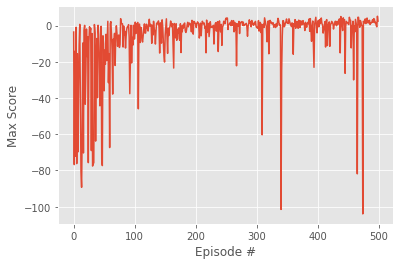

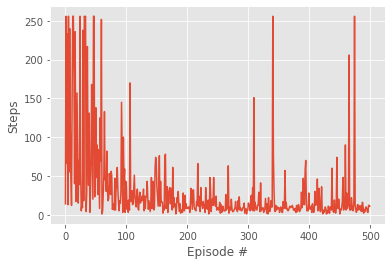

CPU times: user 1min 4s, sys: 1.11 s, total: 1min 6s
Wall time: 1min 6s


In [7]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = gen_wrapped_env(env_name)
state_size = env.observation_space.shape[0]
action_size = 3
agent = DQNAgentGoal(state_size, action_size)
run_episodes_and_display(env, agent, n_episodes=500)

In [8]:
env = gen_wrapped_env(env_name)
run_episode(env, agent, train_mode=False, show_steps=False)

From  [3 1] to [3 5]


(3.585786437626905, 5)

# Learn exploring env

In [ ]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = FlatObsWrapper(gym.make(env_name))
# env = CuriosityWrapper(env)
agent.disable_pretrain(0.0001)
agent.eps = EPS_START
run_episodes_and_display(env, agent, n_episodes=500, pretrain=False)

In [ ]:
env = FlatObsWrapper(gym.make(env_name))
env = CuriosityWrapper(env)
env = Monitor(env, './video', force=True)
run_episode(env, agent, pretrain=False, train_mode=False, show_steps=False)

# Move to goal

In [ ]:
%%time
env_name = 'MiniGrid-Empty-8x8-v0'
env = FlatObsWrapper(gym.make(env_name))
agent.eps = EPS_START
run_episodes_and_display(env, agent, n_episodes=500, pretrain=False)

In [ ]:
env = FlatObsWrapper(gym.make(env_name))
env = Monitor(env, './video', force=True)
run_episode(env, agent, pretrain=False, train_mode=False, show_steps=False)